# 1. Datasets

In [ ]:
from sklearn.datasets import load_digits
from sklearn.datasets import fetch_openml
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn.metrics import mean_squared_error

digits = load_digits()
data_d = digits.data
target_d = digits.target

uk = fetch_openml(name='heart-h', version=3)
data_uk = uk.data
target_uk = uk.target

def five_fold(data):
  ret = []
  fold = len(data)//5
  n = 0
  for i in range(5):
    if i == 4:
      ret.append(range(n, len(data)))
      continue
    ret.append(range(n, n+fold))
    n = n + fold
  return ret

# Data Visualization (Dataset 1)

In [ ]:
# Train-validation-split
digits = load_digits()
X = digits.data
y = digits.target
print("X shape: ", X.shape)
print("y shape: ", y.shape)

X shape:  (1797, 64)
y shape:  (1797,)


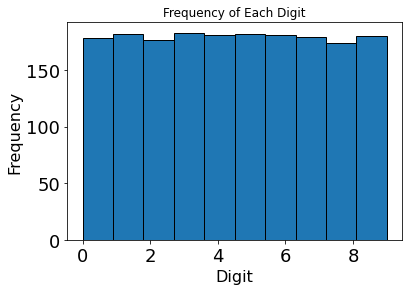

In [ ]:
ax = plt.gca()
plt.hist(y, edgecolor="black")
plt.title("Frequency of Each Digit", fontsize=30)
plt.xlabel("Digit", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.gca().set(title="Frequency of Each Digit")
ax.xaxis.set_tick_params(labelsize=18)
ax.yaxis.set_tick_params(labelsize=18)

# Data Visualization (Dataset 2)

In [ ]:
X2 = data_uk
y2 = target_uk
print("X shape: ", X2.shape)
print("y shape: ", y2.shape)

X shape:  (294, 13)
y shape:  (294,)


[Text(0, 0.5, 'Frequency'), Text(0.5, 0, 'Target'), Text(0.5, 1.0, 'heart-h')]

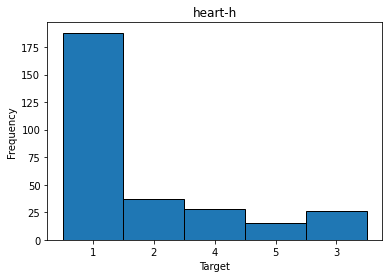

In [ ]:
n = 5
bins=np.arange(0,n+1,1)

fig, ax = plt.subplots(1,1)
ax.hist(y2, bins=bins, align='left', edgecolor="black")
ax.set_xticks(bins[:-1])
fig.gca().set(title="heart-h", xlabel="Target", ylabel="Frequency")

# 3. Gradient Descent

In [ ]:
class MiniBatchGradientDescent:

    def __init__(self, learning_rate=.001, max_iters=1e4, batch_size=32, epsilon=1e-8, momentum=0.9, record_history=False, add_bias = True):
        self.learning_rate = learning_rate
        self.max_iters = max_iters    # Maximum # of iterations we want the optimizer to run
        self.batch_size = batch_size
        self.record_history = record_history  # This parameter to store history of weights is needed if we want to visualize how weights have changed over iterations.
        self.epsilon = epsilon  # hyperparameter for the GradientDescent class. Smaller value of epsilon => will stop early
        self.momentum = momentum
        if record_history:
            self.w_history = []   #to store the weight history for visualization
        self.train_accuracies = []  # to store train accuracies
        self.valid_accuracies = []  # to store validation accuracies
        self.add_bias = add_bias


    # Output: optimal weight
    def run(self, gradient_fn, predict_fn, X_train, y_train, X_valid, y_valid, w): # x is our data
        del_w = w
        print("************************")
        grad = np.inf  # set gradient to infinity => to maximum

        # a function to give batches
        def create_mini_batches(X, y, batch_size):
            mini_batches = []
            #np.random.shuffle()
            n_minibatches = X.shape[0] // batch_size

            i = 0
            for i in range(n_minibatches+1):
                X_mini = X[i*batch_size:(i+1)*batch_size, :]
                y_mini = y[i*batch_size:(i+1)*batch_size]
                mini_batches.append((X_mini, y_mini))
            if n_minibatches % batch_size != 0:
                X_mini = X[i*batch_size: X.shape[0], :]
                y_mini = y[i*batch_size:X.shape[0]]
                mini_batches.append((X_mini, y_mini))
            
            return mini_batches


        # perform mini-batch gradient descent
        error_list = []  # a list to store history of error

        t = 1
        equal_accuracy_Num = 1
        while np.linalg.norm(grad) > self.epsilon and t < self.max_iters:
            mini_batches = create_mini_batches(X, y, self.batch_size)
            for mini_batch in mini_batches:
                X_mini, y_mini = mini_batch
                grad = gradient_fn(X_mini, y_mini, w)
                del_w = (self.momentum)*del_w + (1-self.momentum)*grad
                w = w - (self.learning_rate)*del_w

                if self.record_history:
                    self.w_history.append(w)

            def count_accurate(predicted_labels, true_labels):
                i = 0
                for pred_label, true_label in zip(predicted_labels, true_labels):
                    if pred_label == true_label:  # if label is predicted correctly
                        i += 1
                return i
            
            # calculate training accuracy
            predicted_train_labels = predict_fn(X_train, w)
            train_accuracy = count_accurate(predicted_train_labels, y_train)/len(y_train)
            self.train_accuracies.append(train_accuracy)

            # calculate validation accuracy
            predicted_valid_labels = predict_fn(X_valid, w)
            valid_accuracy = count_accurate(predicted_valid_labels, y_valid)/len(y_valid)
            
            # add termination condition
            if self.valid_accuracies:
              if valid_accuracy == self.valid_accuracies[-1]:
                  equal_accuracy_Num += 1
                  if equal_accuracy_Num == 10:
                      break
              else:
                  equal_accuracy_Num = 1

            self.valid_accuracies.append(valid_accuracy)
            #print("validation accuracies = ", self.valid_accuracies)
            t += 1
            
        return w, self.w_history, self.train_accuracies, self.valid_accuracies
      

# 2. Softmax Regression

In [ ]:
class SoftmaxRegression:

    def __init__(self, classes=2, batch_size=32, add_bias=False):
        self.add_bias = add_bias
        self.batch_size = batch_size
        self.classes = classes
        self.train_set_accuracies = []
        self.valid_set_accuracies = []
        pass

    def softmax(z):
        # z = Xw which is the dot product of input data X and its weight w
        return (np.exp(z.T) / np.sum(np.exp(z), axis=1)).T
        # return a matrix that has been trained by logistic function
    
    def oneHot(y, n_classes):
        """ one hot encoding """
        one_hot = np.zeros((len(y), n_classes))
        one_hot[np.arange(len(y)), y] = 1
        return one_hot


    # turn probabilities into class labels
    def to_label(z):
        #print("to_label Entered")
        return z.argmax(axis=1)

    def predict_prob(self, X, w):
        Xw = np.dot(X,w)
        sfmx = SoftmaxRegression
        sftmx = sfmx.softmax(Xw)
        return sftmx

    def predict_label(self, X, w):
        probs = self.predict_prob(X, w)
        sfmx = SoftmaxRegression
        return sfmx.to_label(probs)


    def cross_entropy(output, y_target):
        return - np.sum(np.log(output) * (y_target), axis=1)

    # calculate cost function via cross_entropy
    def cost(output, y_target):
        return np.mean(cross_entropy(output, y_target))

    def fit(self, X_train, y_train, X_valid, y_valid, optimizer):
        if X_train.ndim == 1:
            X_train = X_train[:, None] 
        if self.add_bias:
            N = X_train.shape[0]
            N_valid = X_valid.shape[0]
            X_train = np.column_stack([X_train, np.ones(N)])
            X_valid = np.column_stack([X_valid, np.ones(N_valid)])
                
        def gradient(X_mini, y_mini, w):
            z = np.dot(X_mini, w)
            sfmx = SoftmaxRegression
            yh = sfmx.softmax(z)
            y_onehot = sfmx.oneHot(y_mini, self.classes)
            N,D = X_mini.shape
            grad = np.dot(X_mini.T, yh - y_onehot)/len(y)
            return grad

        N,D = X_train.shape # N: number of classes, D: number of features  
        w0 = np.zeros((D, self.classes))
        self.w, self.w_history, self.train_set_accuracies, self.valid_set_accuracies = optimizer.run(gradient, self.predict_label, X_train, y_train, X_valid, y_valid, w0)  # gradient, self.predict_proba, X, y, w0
        return self.w, self.w_history, self.train_set_accuracies, self.valid_set_accuracies


#For 5-fold cross validation

In [ ]:
# Train-validation-split
digits = load_digits()
X = digits.data
y = digits.target

In [ ]:
class Kfolds:
    def __init__(self, n_splits, shuffle=True, seed=4321):
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.seed = seed
    
    def split_data(self, X):
        n_samples = X.shape[0]
        #print("n_samples: ", n_samples)
        indices = np.arange(n_samples)
        if self.shuffle:
            rand_state = np.random.RandomState(self.seed)
            rand_state.shuffle(indices)

        for test_mask in self.iter_test_masks(n_samples, indices):
            train_index = indices[np.logical_not(test_mask)]
            test_index = indices[test_mask]
            yield train_index, test_index
    
    def iter_test_masks(self, n_samples, indices):
        fold_sizes = (n_samples//self.n_splits)*np.ones(self.n_splits, dtype=np.int)
        fold_sizes[:n_samples % self.n_splits] += 1

        current = 0
        print("fold_sizes = ", fold_sizes)
        for fold_size in fold_sizes:
            start, stop = current, current + fold_size
            test_indices = indices[start:stop]
            test_mask = np.zeros(n_samples, dtype=np.bool)
            test_mask[test_indices] = True
            yield test_mask
            current = stop

In [ ]:
import time
def Cross_Validation(X, y, lr, iteration, batch_siz, mmtm): 
    kf = Kfolds(n_splits=5, shuffle=True, seed=4312)
    sum_valid_accu = 0
    avg_valid_acc = 0
    sum_train_accu = 0
    avg_train_acc = 0
    sum_run_time = 0
    avg_run_time = 0
    for train_index, valid_index in kf.split_data(X):
        print("================================================")
        
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]

        optimizer = MiniBatchGradientDescent(learning_rate=lr, max_iters=500, batch_size=batch_siz, epsilon=1e-8, momentum=mmtm, record_history=True)  #1000
        model = SoftmaxRegression(classes=10)

        start_time = time.time()  # record start time

        w, w_history, train_set_accuracies, valid_set_accuracies = model.fit(X_train, y_train, X_valid, y_valid, optimizer)
        print("valid_set_accuracies: ", valid_set_accuracies)

        end_time = time.time()  # record start time
        time_taken = end_time - start_time  # calculate run time
        sum_run_time += time_taken  # sum the run time

        sum_valid_accu += valid_set_accuracies[-1]
        sum_train_accu += train_set_accuracies[-1]

    avg_valid_acc = sum_valid_accu / 5
    print("average validation accuracy: ", avg_valid_acc)
    avg_train_acc = sum_train_accu / 5
    print("average train accuracy: ", avg_train_acc)
    avg_run_time = sum_run_time / 5
    print("average running time: ", avg_run_time)

    return avg_valid_acc, avg_train_acc, avg_run_time

# Performance of Softmax Regression

************************


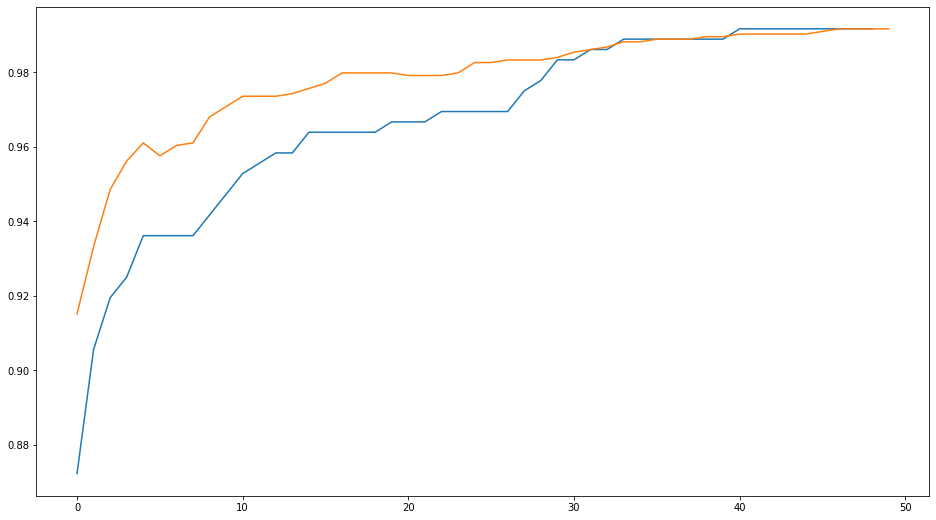

In [ ]:
# X = data_d
# y = target_d
data_uk = uk.data
target_uk = uk.target
'''
X = data_uk
y = target_uk
y = np.array([int(i) for i in y])

print(y[:50])
y = [0 if x==5 else x for x in y]
y = np.array([int(i) for i in y])
print(y[:50])
'''

optimizer = MiniBatchGradientDescent(learning_rate=0.38, max_iters=2000, batch_size=75, epsilon=1e-8, momentum=0.8, record_history=True)  #1000
model = SoftmaxRegression(classes=10)

t_val = int(0.8 * len(X))
w, w_history, train_set_accuracies, valid_set_accuracies = model.fit(X[:t_val], y[:t_val], X[t_val:], y[t_val:], optimizer)

plt.figure(figsize=(16,9))
plt.plot([i for i in range(len(valid_set_accuracies))], valid_set_accuracies, label='Validation Accuracy')
plt.plot([i for i in range(len(train_set_accuracies))], train_set_accuracies, label='Train Accuracy')
plt.show()

In [ ]:
X = data_uk
y = target_uk
y = np.array([int(i) for i in y])

In [ ]:
print(y[:50])
y = [0 if x==5 else x for x in y]
y = np.array([int(i) for i in y])
print(y[:50])

[1 2 1 4 1 1 1 1 2 1 1 4 1 4 1 1 2 1 2 2 1 1 1 4 1 1 1 1 1 1 4 1 2 4 1 1 2
 1 1 1 1 5 1 1 4 1 1 1 1 2]
[1 2 1 4 1 1 1 1 2 1 1 4 1 4 1 1 2 1 2 2 1 1 1 4 1 1 1 1 1 1 4 1 2 4 1 1 2
 1 1 1 1 0 1 1 4 1 1 1 1 2]


Streaming output truncated to the last 5000 lines.
 2]
[0 0 0 0 0 4 2 0 3 0 3 4 0 0 0 0 3 4 0 0 0 0 0 0 0 4 4 3 0 0 0 1 0 3 0 0 2
 0 1 0 3 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 1 0 2 0 0 0 2 1 0
 0]
[0 1 0 1 0 0 0 0 0 0 0 0 4 3 2 2 0 2 3 0 1 0 2 2 2 3 4 1 0 0 3 0 0 0 0 0 0
 0 2 3 1 0 3 0 2 0 0 0 1 0 0 0 3 2 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0 0 0 4 3 2 2 0 2 3 0 1 0 2 2 2 3 4 1 0 0 3 0 0 0 0 0 0
 0 2 3 1 0 3 0 2 0 0 0 1 0 0 0 3 2 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0]
[0 1 0 3 0 0 0 0 1 0 0 3 0 3 0 0 1 0 1 1 0 0 0 3 0 0 0 0 0 0 3 0 1 3 0 0 1
 0 0 0 0 4 0 0 3 0 0 0 0 1 2 4 0 0 0 0 1 1 0 3 0 0 0 1 0 0 0 0 3 0 1 0 2 0
 2]
[0 2 0 0 1 0 0 1 0 2 3 3 0 2 0 0 0 0 2 0 2 0 0 0 0 4 0 2 1 1 0 0 0 0 0 0 2
 0 0 0 1 1 1 0 1 3 0 0 4 0 0 0 0 0 0 0 1 3 3 0 1 0 0 2 1 4 4 4 0 3 0 0 0 0
 2]
[0 0 0 0 0 4 2 0 3 0 3 4 0 0 0 0 3 4 0 0 0 0 0 0 0 4 4 3 0 0 0 1 0 3 0 0 2
 0 1 0 3 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 1 0 2 0 0 0 2 1 0
 0]
[0 1 0 1 0 0 0 0 0 0 0 0 4 3 2 2 0 2 3 0 1 0 2 

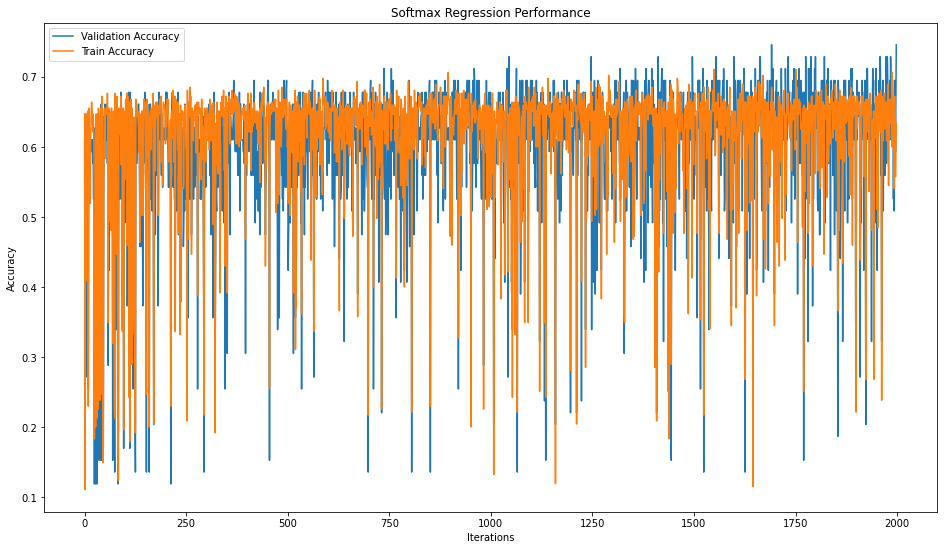

In [ ]:
#print(X.shape)
#validation_accuracy, train_acc, runtime = Cross_Validation(X, y, 0.038, 2000, 75, 0.8)
# model = SoftmaxRegression(classes=10)
X = data_uk
y = target_uk
y = np.array([int(i) for i in y])

optimizer = MiniBatchGradientDescent(learning_rate=0.05, max_iters=2000, batch_size=75, epsilon=1e-8, momentum=0.8, record_history=True)  #1000
model = SoftmaxRegression(classes=5)

t_val = int(0.8 * len(X))
w, w_history, train_set_accuracies, valid_set_accuracies = model.fit(X[:t_val], y[:t_val], X[t_val:], y[t_val:], optimizer)

plt.figure(figsize=(16,9))
plt.plot([i for i in range(len(valid_set_accuracies))], valid_set_accuracies, label='Validation Accuracy')
plt.plot([i for i in range(len(train_set_accuracies))], train_set_accuracies, label='Train Accuracy')
plt.title('Softmax Regression Performance')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.show()

# 5. Hyper-parameters analysis

In [ ]:
# Train-validation-split
digits = load_digits()
X = digits.data
y = digits.target

print("X shape: ", X.shape)
print("y shape: ", y.shape)

X shape:  (1797, 64)
y shape:  (1797,)


In [ ]:
X = data_uk
y = target_uk
print("X shape: ", X2.shape)
print("y shape: ", y2.shape)

X shape:  (294, 13)
y shape:  (294,)


In [ ]:
print(X.shape)
#validation_accuracy, train_acc, runtime = Cross_Validation(X, y, 0.038, 2000, 75, 0.8)
# model = SoftmaxRegression(classes=10)

optimizer = MiniBatchGradientDescent(learning_rate=0.38, max_iters=2000, batch_size=75, epsilon=1e-8, momentum=0.8, record_history=True)  #1000
model = SoftmaxRegression(classes=10)

w, w_history, train_set_accuracies, valid_set_accuracies = model.fit(X[:1500], y[:1500], X[1500:], y[1500:], optimizer)

plt.figure(figsize=(16,9))
plt.plot([i for i in range(len(valid_set_accuracies))], valid_set_accuracies, label='Validation Accuracy')
plt.plot([i for i in range(len(train_set_accuracies))], train_set_accuracies, label='Train Accuracy')
plt.title('Softmax Regression Performance')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.show()lrs = [0.001 + 0.001*i for i in range(50)]
accuracy_valid_list_lr = []
accuracy_train_list_lr = []
runtime_list_lr = []

optimal_lr = 0
for lr in lrs:
    avg_validation_accuracy, avg_train_acc, avg_runtime = Cross_Validation(X, y, lr, 200, 32, 0.9)  # for that particular learning rate
    accuracy_valid_list_lr.append(avg_validation_accuracy)
    accuracy_train_list_lr.append(avg_train_acc)
    runtime_list_lr.append(avg_runtime)

    if avg_validation_accuracy >= max(accuracy_valid_list_lr):
        optimal_lr = lr

print('\noptimal learning rate:', optimal_lr)

plt.figure(figsize=(16,9))
plt.plot(lrs, accuracy_valid_list_lr, label='Validation Accuracy')
plt.plot(lrs, accuracy_train_list_lr, label='Train Accuracy')
plt.title('Validation accuracy with different learning rate')
plt.legend()
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.show()

plt.figure(figsize=(16,9))
plt.plot(lrs, runtime_list_lr)
plt.title('Runing time with different learning rate')
plt.xlabel('Learning Rate')
plt.ylabel('Running Time')
plt.show()

SyntaxError: ignored

In [ ]:
b_sizes = [5 + 5*i for i in range(20)]
accuracy_list_bsize = []
runtime_list_bsize = []
accuracy_train_bsize = []
optimal_batch_size = 0  # set optimal batch size
for bsize in b_sizes:
    avg_validation_accuracy, avg_train_acc, avg_runtime = Cross_Validation(X, y, 0.01, 200, bsize, 0.9)  # for that particular learning rate
    accuracy_list_bsize.append(avg_validation_accuracy)
    runtime_list_bsize.append(avg_runtime)
    accuracy_train_bsize.append(avg_train_acc)

    if avg_validation_accuracy >= max(accuracy_list_bsize):
        optimal_batch_size = bsize

print('\noptimal batch size:', optimal_batch_size)


plt.figure(figsize=(16,9))
plt.plot(b_sizes, accuracy_list_bsize, label='Validation Accuracy')
plt.plot(b_sizes, accuracy_train_bsize, label='Train Accuracy')
plt.title('Accuracy with different batch size')
plt.legend()
plt.xlabel('Batch Size')
plt.ylabel('Accuracy')
plt.show()

plt.figure(figsize=(16,9))
plt.plot(b_sizes, runtime_list_bsize)
plt.title('Runtime with different batch size')
plt.xlabel('Batch Size')
plt.ylabel('Run Time')
plt.show()

fold_sizes =  [59 59 59 59 58]
************************
valid_set_accuracies:  [0.711864406779661, 0.711864406779661, 0.711864406779661, 0.6949152542372882, 0.711864406779661, 0.711864406779661, 0.711864406779661, 0.6949152542372882, 0.6949152542372882, 0.6610169491525424, 0.6949152542372882, 0.711864406779661, 0.6949152542372882, 0.6949152542372882, 0.711864406779661, 0.6949152542372882, 0.6949152542372882, 0.6949152542372882, 0.711864406779661, 0.711864406779661, 0.6949152542372882, 0.6949152542372882, 0.6949152542372882, 0.6610169491525424, 0.6949152542372882, 0.6949152542372882, 0.6949152542372882, 0.6949152542372882, 0.711864406779661, 0.711864406779661, 0.711864406779661, 0.711864406779661, 0.711864406779661, 0.711864406779661, 0.6949152542372882, 0.711864406779661, 0.711864406779661, 0.711864406779661, 0.711864406779661, 0.711864406779661, 0.711864406779661, 0.7288135593220338, 0.6949152542372882, 0.711864406779661, 0.711864406779661, 0.711864406779661, 0.7288135593220338, 0.711

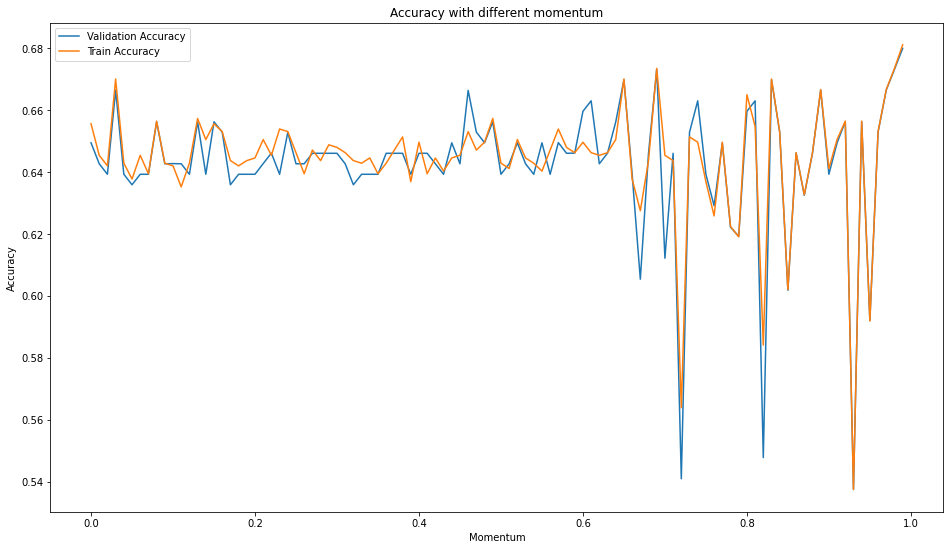

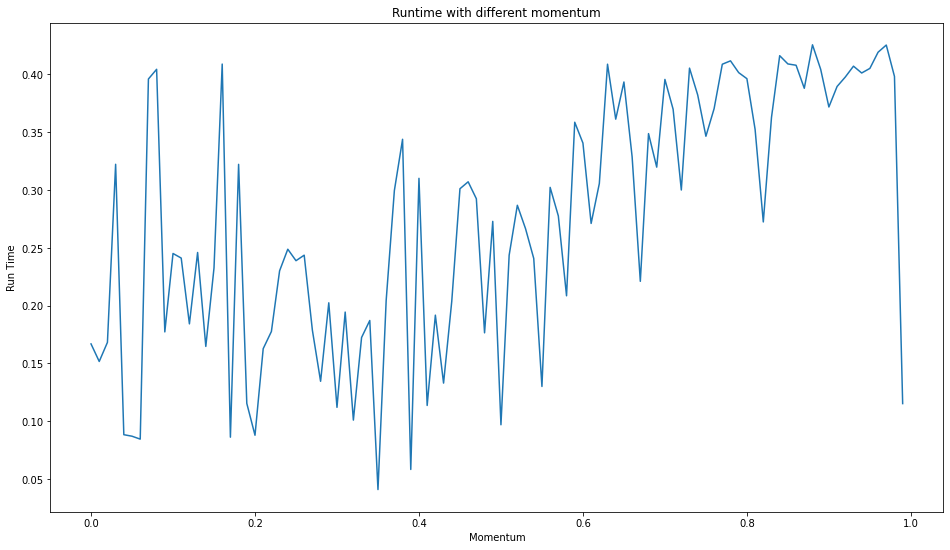

In [ ]:
moms = [0 + 0.01*i for i in range(100)]
accuracy_list_mom = []
accuracy_train_mom = []
runtime_list_mom = []

optimal_mom = 0
for mom in moms:
    avg_validation_accuracy, avg_train_acc, avg_runtime = Cross_Validation(X, y, 0.01, 200, 45, mom)  # for that particular learning rate
    accuracy_list_mom.append(avg_validation_accuracy)
    accuracy_train_mom.append(avg_train_acc)
    runtime_list_mom.append(avg_runtime)
    
    if avg_validation_accuracy >= max(accuracy_list_mom):
        optimal_mom = mom

print('\noptimal momentum:', optimal_mom)

plt.figure(figsize=(16,9))
plt.plot(moms, accuracy_list_mom, label='Validation Accuracy')
plt.plot(moms, accuracy_train_mom, label='Train Accuracy')
plt.title('Accuracy with different momentum')
plt.legend()
plt.xlabel('Momentum')
plt.ylabel('Accuracy')
plt.show()

plt.figure(figsize=(16,9))
plt.plot(moms, runtime_list_mom)
plt.title('Runtime with different momentum')
plt.xlabel('Momentum')
plt.ylabel('Run Time')
plt.show()


# Comparison with KNN (Dataset 1)

In [ ]:
def count_acc(predicted_labels, true_labels):
  i = 0
  for pred_label, true_label in zip(predicted_labels, true_labels):
    if pred_label == true_label:  # if label is predicted correctly
      i += 1
  return i/len(true_labels)

r = five_fold(data_d)
Ks = []
Accs = []
# 5-fold KNN
for K in range(20):
    K = K+1
    Ks.append(K)
    model = neighbors.KNeighborsClassifier(n_neighbors = K)
    acc = 0
    for i in range(len(r)):
      x_test = data_d[r[i]]
      y_test = target_d[r[i]]
      x_train = np.delete(data_d, r[i], 0)
      y_train = np.delete(target_d, r[i], 0)
      model.fit(x_train, y_train)
      pred = model.predict(x_test)
      acc = acc + count_acc(y_test,pred)
    acc_new = acc / len(r)
    Accs.append(acc_new)
    print('Accuracy for k= ' , K , 'is:', acc_new)

xint = range(1, math.ceil(max(Ks))+1)
plt.figure(figsize=(16,9))
plt.title('Accuracy of KNN (Dataset 1)')
plt.plot(Ks, Accs)
plt.xticks(xint)
plt.xlabel('K value')
plt.ylabel('Accuracy')
plt.show()


# Database2: heart-h

In [ ]:

#data_ac = fetch_openml(name='artificial-characters', version=1)
uk = fetch_openml(name='heart-h', version=3)
data_uk = uk.data
target_uk = uk.target

X = data_uk
y = target_uk
y = np.array([int(i) for i in y])
print(y)

lrs = [0.001 + 0.001*i for i in range(50)]
accuracy_valid_list_lr = []
accuracy_train_list_lr = []
runtime_list_lr = []

optimal_lr = 0
for lr in lrs:
    avg_validation_accuracy, avg_train_acc, avg_runtime = Cross_Validation(X, y, lr, 200, 32, 0.9)  # for that particular learning rate
    accuracy_valid_list_lr.append(avg_validation_accuracy)
    accuracy_train_list_lr.append(avg_train_acc)
    runtime_list_lr.append(avg_runtime)

    if avg_validation_accuracy >= max(accuracy_valid_list_lr):
        optimal_lr = lr

print('\noptimal learning rate:', optimal_lr)

plt.figure(figsize=(16,9))
plt.plot(lrs, accuracy_valid_list_lr, label='Validation Accuracy')
plt.plot(lrs, accuracy_train_list_lr, label='Train Accuracy')
plt.title('Validation accuracy with different learning rate')
plt.legend()
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.show()

plt.figure(figsize=(16,9))
plt.plot(lrs, runtime_list_lr)
plt.title('Runing time with different learning rate')
plt.xlabel('Learning Rate')
plt.ylabel('Running Time')
plt.show()


In [ ]:
b_sizes = [5 + 5*i for i in range(20)]
accuracy_list_bsize = []
runtime_list_bsize = []
accuracy_train_bsize = []
optimal_batch_size = 0  # set optimal batch size
for bsize in b_sizes:
    avg_validation_accuracy, avg_train_acc, avg_runtime = Cross_Validation(X, y, 0.01, 200, bsize, 0.9)  # for that particular learning rate
    accuracy_list_bsize.append(avg_validation_accuracy)
    runtime_list_bsize.append(avg_runtime)
    accuracy_train_bsize.append(avg_train_acc)

    if avg_validation_accuracy >= max(accuracy_list_bsize):
        optimal_batch_size = bsize

print('\noptimal batch size:', optimal_batch_size)


plt.figure(figsize=(16,9))
plt.plot(b_sizes, accuracy_list_bsize, label='Validation Accuracy')
plt.plot(b_sizes, accuracy_train_bsize, label='Train Accuracy')
plt.title('Accuracy with different batch size')
plt.legend()
plt.xlabel('Batch Size')
plt.ylabel('Accuracy')
plt.show()

plt.figure(figsize=(16,9))
plt.plot(b_sizes, runtime_list_bsize)
plt.title('Runtime with different batch size')
plt.xlabel('Batch Size')
plt.ylabel('Run Time')
plt.show()


In [ ]:
moms = [0 + 0.01*i for i in range(100)]
accuracy_list_mom = []
accuracy_train_mom = []
runtime_list_mom = []

optimal_mom = 0
for mom in moms:
    avg_validation_accuracy, avg_train_acc, avg_runtime = Cross_Validation(X, y, 0.01, 200, 45, mom)  # for that particular learning rate
    accuracy_list_mom.append(avg_validation_accuracy)
    accuracy_train_mom.append(avg_train_acc)
    runtime_list_mom.append(avg_runtime)
    
    if avg_validation_accuracy >= max(accuracy_list_mom):
        optimal_mom = mom

print('\noptimal batch size:', optimal_mom)

plt.figure(figsize=(16,9))
plt.plot(moms, accuracy_list_mom, label='Validation Accuracy')
plt.plot(moms, accuracy_train_mom, label='Train Accuracy')
plt.title('Accuracy with different momentum')
plt.legend()
plt.xlabel('Momentum')
plt.ylabel('Accuracy')
plt.show()

plt.figure(figsize=(16,9))
plt.plot(moms, runtime_list_mom)
plt.title('Runtime with different momentum')
plt.xlabel('Momentum')
plt.ylabel('Run Time')
plt.show()


# Comparison with KNN (Dataset 2)

Accuracy for k=  1 is: 0.49010011123470526
Accuracy for k=  2 is: 0.5954393770856508
Accuracy for k=  3 is: 0.5814238042269188
Accuracy for k=  4 is: 0.6053392658509454
Accuracy for k=  5 is: 0.6090100111234704
Accuracy for k=  6 is: 0.6296996662958844
Accuracy for k=  7 is: 0.6296996662958844
Accuracy for k=  8 is: 0.6331479421579533
Accuracy for k=  9 is: 0.6331479421579532
Accuracy for k=  10 is: 0.6400444938820912
Accuracy for k=  11 is: 0.6398220244716352
Accuracy for k=  12 is: 0.6294771968854282
Accuracy for k=  13 is: 0.639599555061179
Accuracy for k=  14 is: 0.639599555061179
Accuracy for k=  15 is: 0.639599555061179
Accuracy for k=  16 is: 0.639599555061179
Accuracy for k=  17 is: 0.6361512791991102
Accuracy for k=  18 is: 0.643047830923248
Accuracy for k=  19 is: 0.639599555061179
Accuracy for k=  20 is: 0.6361512791991102
Accuracy for k=  21 is: 0.6361512791991102
Accuracy for k=  22 is: 0.6361512791991102
Accuracy for k=  23 is: 0.6361512791991102
Accuracy for k=  24 is: 0

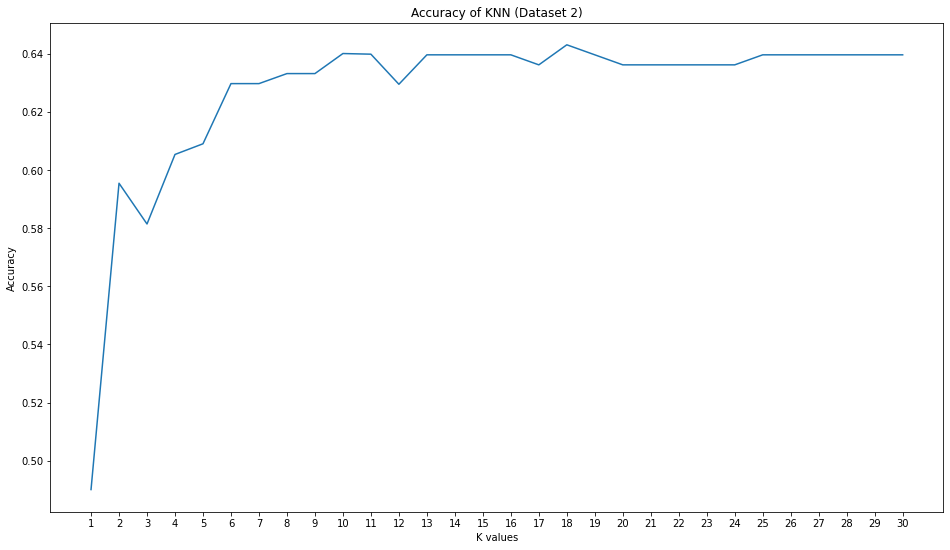

In [ ]:
def count_acc(predicted_labels, true_labels):
  i = 0
  for pred_label, true_label in zip(predicted_labels, true_labels):
    if pred_label == true_label:  # if label is predicted correctly
      i += 1
  return i/len(true_labels)

uk = fetch_openml(name='heart-h', version=3)
data_uk = uk.data
target_uk = uk.target

r = five_fold(data_uk)
Ks = []
Accs = []
# 5-fold KNN
for K in range(30):
    K = K+1
    Ks.append(K)
    model = neighbors.KNeighborsClassifier(n_neighbors = K)
    acc = 0
    for i in range(len(r)):
      x_test = data_uk[r[i]]
      y_test = target_uk[r[i]]
      x_train = np.delete(data_uk, r[i], 0)
      y_train = np.delete(target_uk, r[i], 0)
      model.fit(x_train, y_train)
      pred = model.predict(x_test)
      acc = acc + count_acc(y_test,pred)
    acc_new = acc / len(r)
    Accs.append(acc_new)
    print('Accuracy for k= ' , K , 'is:', acc_new)

xint = range(1, math.ceil(max(Ks))+1)
plt.figure(figsize=(16,9))
plt.plot(Ks, Accs)
plt.xticks(xint)
plt.title('Accuracy of KNN (Dataset 2)')
plt.xlabel('K values')
plt.ylabel('Accuracy')
plt.show()

# Naive Bayes (extra)

0.27419354838709675


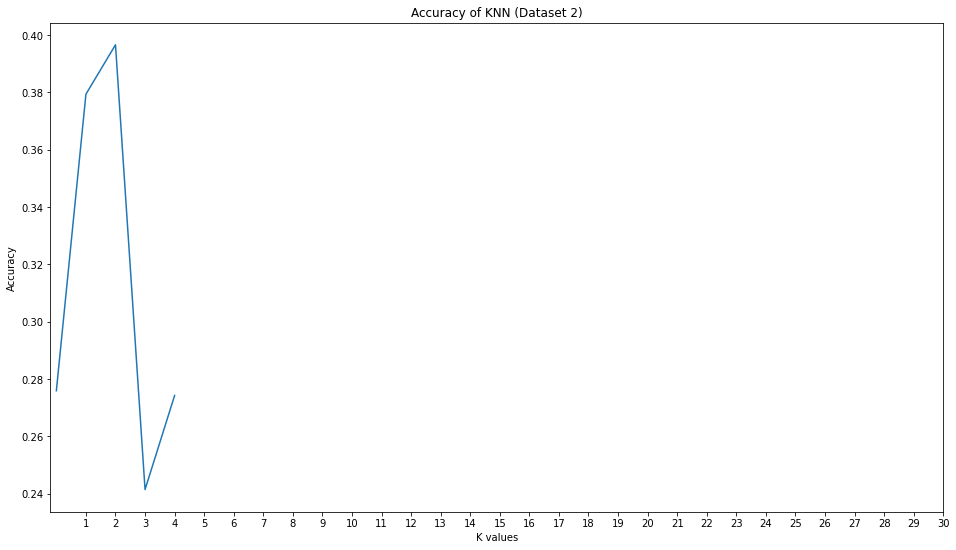

In [ ]:
from sklearn.naive_bayes import GaussianNB

uk = fetch_openml(name='heart-h', version=3)
data_uk = uk.data
target_uk = uk.target

#Create a Gaussian Classifier
model = GaussianNB()

r = five_fold(data_uk)

Accs = []
accuracy = 0
for i in range(len(r)):
# Train the model using the training sets
    x_test = data_uk[r[i]]
    y_test = target_uk[r[i]]
    x_train = np.delete(data_uk, r[i], 0)
    y_train = np.delete(target_uk, r[i], 0)

    model.fit(x_train,y_train)
    pred = model.predict(x_test)
    accuracy = count_acc(y_test,pred)
    Accs.append(accuracy)
print(accuracy)

#xint = range(1, math.ceil(max(Ks))+1)
plt.figure(figsize=(16,9))
plt.plot(range(5), Accs)
plt.xticks(xint)
plt.title('Accuracy of KNN (Dataset 2)')
plt.xlabel('K values')
plt.ylabel('Accuracy')
plt.show()
#print(data_uk[1])
# pred = model.predict(data_uk[1])